In [1]:
from IPython.display import display
import pandas as pd
import pf_functions as func
import numpy as np

In [2]:
import ipywidgets as widgets

In [3]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import os

In [4]:
import sys
sys.path.append('C:/Users/bheim/PythonProjects/AMTDpy')

In [5]:
import AMTDpy as td #my own user defined package for getting stock prices
import pf_functions as func

In [6]:
sys.path.append('C:/Users/bheim/PythonProjects/Coinpy')
import cryptocompare as crypto
import cryptoconfig as ccf

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
ticks = ['DGRO', 'IWO', 'EMTL', 'GLD', "JNK", "IUSV"]

In [9]:
from time import sleep
tdata = {}
tdf = pd.DataFrame()
for i in ticks:
    tdata[str(i)] = func.get_ticker_df(str(i), 1)
    tdf = pd.concat([tdf, tdata[str(i)]], axis = 1)
    sleep(2)
tdf.shape 

(252, 48)

In [10]:
returns = tdf.filter(like='returns')
returns.columns = list(tdata)
returns = returns.reindex(sorted(returns.columns), axis=1)
returns.head()

,DGRO,EMTL,GLD,IUSV,IWO,JNK
datetime,,,,,,
2018-12-10 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-11 06:00:00,-0.001190,-0.000576,-0.002503,-0.001505,0.001263,0.002611
2018-12-12 06:00:00,0.002125,0.004886,0.003656,0.011259,0.001074,0.002894
2018-12-13 06:00:00,-0.002210,0.000000,-0.001730,-0.015339,-0.001706,0.002597
2018-12-14 06:00:00,-0.004007,-0.017935,-0.014729,-0.016887,-0.000632,-0.004332


In [11]:
btc = crypto.get_coin_hist("BTC","USD", 252, ccf.apikey, clip=1)

In [12]:
btc.head()

,close,high,low,open,time,volumefrom,volumeto
0,4976.59,5335.70,4831.59,4906.93,2019-04-02 20:00:00,159843.43,8.091583e+08
1,4913.36,5071.98,4799.77,4976.59,2019-04-03 20:00:00,74544.88,3.701090e+08
2,5047.23,5074.13,4897.61,4913.36,2019-04-04 20:00:00,56130.82,2.807222e+08
3,5057.25,5240.19,4938.00,5047.23,2019-04-05 20:00:00,54180.91,2.758396e+08
4,5201.16,5266.04,5044.28,5057.25,2019-04-06 20:00:00,47200.43,2.433299e+08


In [13]:
btc = btc.set_index('time')

In [14]:
btc.index = pd.to_datetime(btc.index.date)

In [15]:
returns.index = pd.to_datetime(returns.index.date)

In [16]:
import AMTDpy as td #my own user defined package for getting stock prices
import pf_functions as func


In [17]:
btc_ret = func.calc_returns(btc['close'])

In [18]:
all_ret = pd.concat([btc_ret, returns], axis =1).dropna()
all_ret = all_ret.rename(columns ={'close': "BTC"})
print(all_ret.shape)
all_ret.head()

(174, 7)


,BTC,DGRO,EMTL,GLD,IUSV,IWO,JNK
2019-04-03,-0.012787,-0.001477,0.001886,0.001800,0.007398,-0.001109,0.000279
2019-04-04,0.026882,0.002542,0.002956,0.005632,0.000451,0.000030,0.001951
2019-04-05,0.001983,-0.001065,0.004551,0.006166,0.009825,0.001582,0.001391
2019-04-08,-0.017683,0.004336,0.001068,0.001421,-0.002883,0.000101,-0.000278
2019-04-09,0.022302,0.005210,-0.006424,-0.008018,-0.011715,0.001308,0.000000


In [29]:
def show_cppi(mu, sigma, s_0, m=3, scenarios = 100, start = 10000, floor = .7, drawdown = .1, legend = False):
    """plot monte carlo sim of the CPPI"""
    sim_rets = func.gbm(n_scenarios = scenarios, mu = mu , sigma= sigma, s_0 = s_0, returns=True)
    risky_r = pd.DataFrame(sim_rets)
    risky_r.columns = risky_r.columns.astype(str)
    btr = func.run_cppi(risky_r, m =m, start = start, floor = floor, drawdown = drawdown, plot_floors = True, legend = legend)

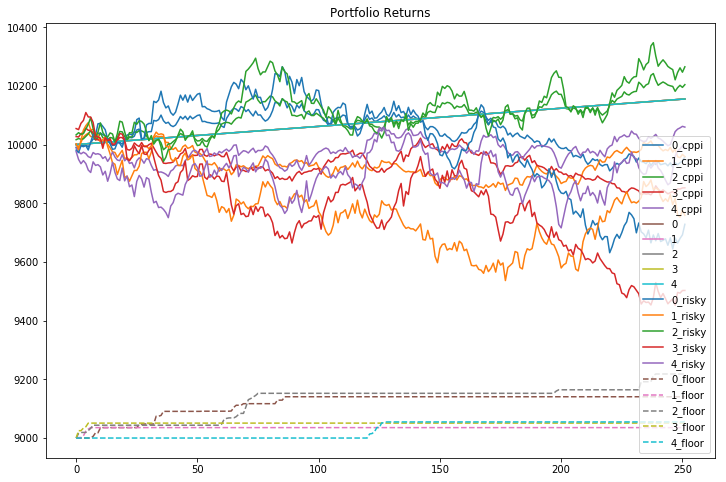

In [30]:
show_cppi(all_ret.BTC.mean(), all_ret.BTC.std(), s_0 = btc.close[1], floor=.9, scenarios = 5, legend = True, m=5)

In [41]:
 all_ret.BTC.std()/10

0.00394976532901307

In [52]:
cppi_controls = widgets.interactive(func.show_cppi, 
                    scenarios = (5, 500, 5), # starts at 5, goes to 500, steps of 5
                    mu = (all_ret.IUSV.mean() - all_ret.IUSV.mean()*2, all_ret.BTC.mean() + all_ret.IUSV.mean()*2, abs(all_ret.IUSV.mean()/5)), 
                    sigma =  (0, all_ret.IUSV.std() + all_ret.IUSV.std()*2, all_ret.IUSV.std()/10),
                    s_0 = tdata['IUSV'].close[1],
                    m = (1,5,1),
                    floor = (.7,.95,.05),
                    drawdown = widgets.Dropdown(options=[0,.05,.1,.15,.2, None], value =None, Description="Drawdown")
                                  )

In [53]:
display(cppi_controls)

interactive(children=(FloatSlider(value=0.0, description='mu', max=0.00046571912083279344, min=-0.000346965668…

C:\Users\bheim\PythonProjects\edhec_portfolio_opt\pf_functions.py:191: OptimizeWarning: Unknown solver options: display
  bounds=bounds)


             DGRO      EMTL           GLD  IUSV       IWO  JNK
Weights  0.270694  0.274932  7.345918e-13   0.0  0.454373  0.0


Returns: 0.07272744016653114


Volatility: 0.002779954394189949


C:\Users\bheim\PythonProjects\edhec_portfolio_opt\pf_functions.py:229: OptimizeWarning: Unknown solver options: display
  bounds=bounds)
C:\Users\bheim\PythonProjects\edhec_portfolio_opt\pf_functions.py:261: OptimizeWarning: Unknown solver options: display
  bounds=bounds)


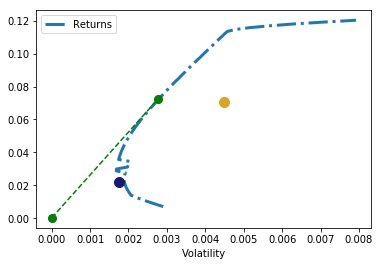

In [55]:
func.plot_ef(all_ret.drop(columns=['BTC']))

C:\Users\bheim\PythonProjects\edhec_portfolio_opt\pf_functions.py:191: OptimizeWarning: Unknown solver options: display
  bounds=bounds)
C:\Users\bheim\PythonProjects\edhec_portfolio_opt\pf_functions.py:229: OptimizeWarning: Unknown solver options: display
  bounds=bounds)
C:\Users\bheim\PythonProjects\edhec_portfolio_opt\pf_functions.py:261: OptimizeWarning: Unknown solver options: display
  bounds=bounds)


         BTC      DGRO      EMTL           GLD  IUSV      IWO  JNK
Weights  0.0  0.270688  0.274932  1.099438e-12   0.0  0.45438  0.0


Returns: 0.07272675042144422


Volatility: 0.0027799279723078993


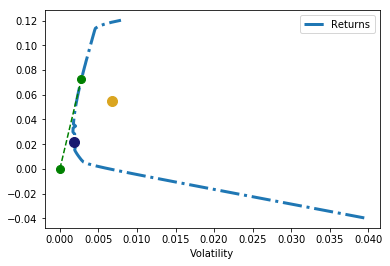

In [56]:
func.plot_ef(all_ret)

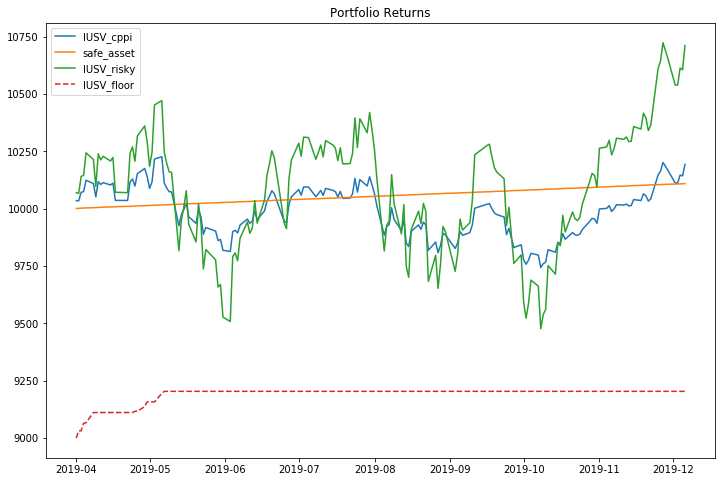

In [212]:
iusv_cppi  = func.run_cppi(pd.DataFrame(all_ret['IUSV']), m =5, start = 10000, floor = .95, drawdown = .1, plot_floors = True, legend = True)

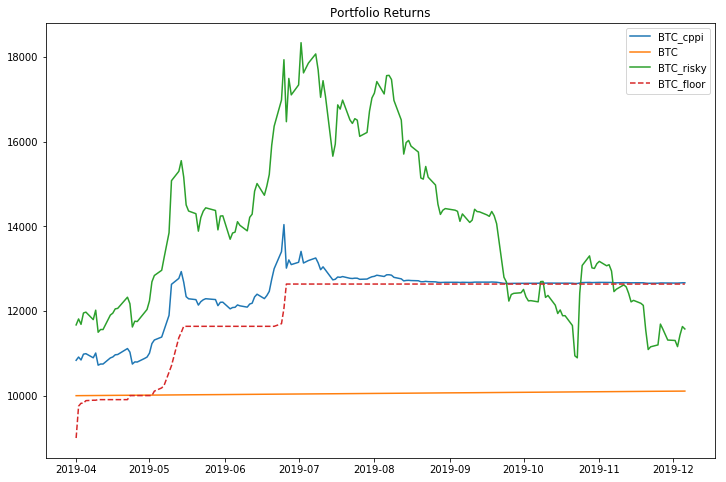

In [215]:
btc_cppi  = func.run_cppi(pd.DataFrame(all_ret['BTC']), m =5, start = 10000, floor = .95, drawdown=.1, plot_floors = True, legend = True)

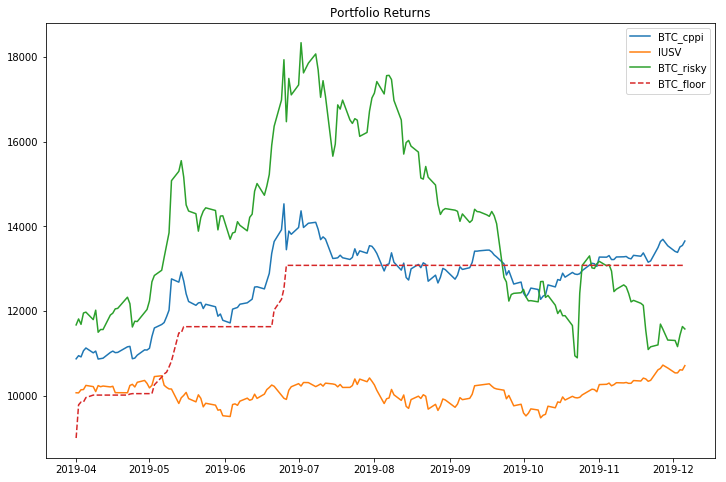

In [217]:
#THIS IS INTERESTING - USING IUSV AS SAFE ASSET AND BTC AS RISKY - EMPLOY CPPI for max returns

btc_iusv  = func.run_cppi(pd.DataFrame(all_ret['BTC']), safe_r = all_ret['IUSV'], m =5, start = 10000, floor = .95, drawdown=.1, plot_floors = True, legend = True)

In [220]:
btc_iusv['All Portfolios'].iloc[-1]

BTC_cppi     13654.229270
IUSV         10710.450712
BTC_risky    11576.242837
Name: 2019-12-06 00:00:00, dtype: float64

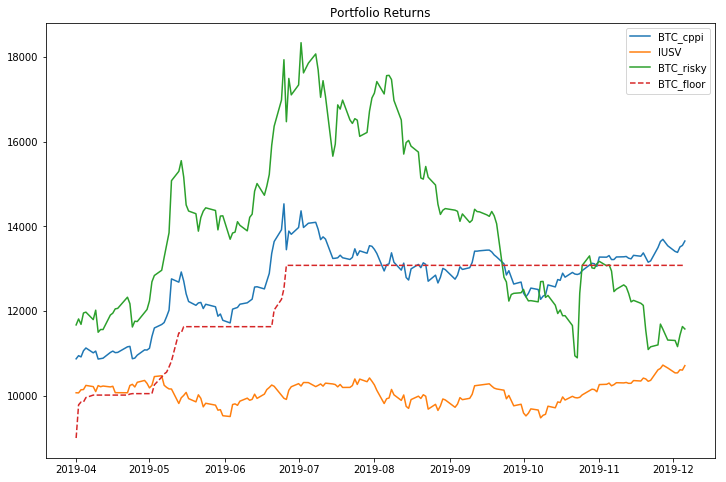

In [230]:
btc_iusv  = func.run_cppi(pd.DataFrame(all_ret['BTC']), safe_r = all_ret['IUSV'], m =5, start = 10000, floor = .90, drawdown=.1, plot_floors = True, legend = True)

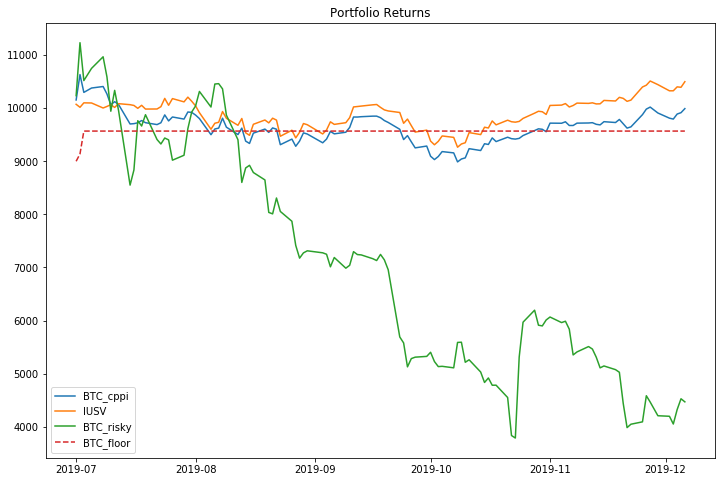

In [233]:
btc_iusv  = func.run_cppi(pd.DataFrame(all_ret['BTC']['2019-07-01':]), safe_r = all_ret['IUSV']['2019-07-01':], m =5, start = 10000, floor = .90, drawdown=.1, plot_floors = True, legend = True)